1/1 [==============================] - 0s 38ms/step

📈 Forecast Evaluation:
MSE: 0.03784
MAE: 0.12575
1/1 [==============================] - 0s 31ms/step

🚨 Detection Evaluation:
Precision: 0.82857
Recall:    0.71311
F1 Score:  0.76652


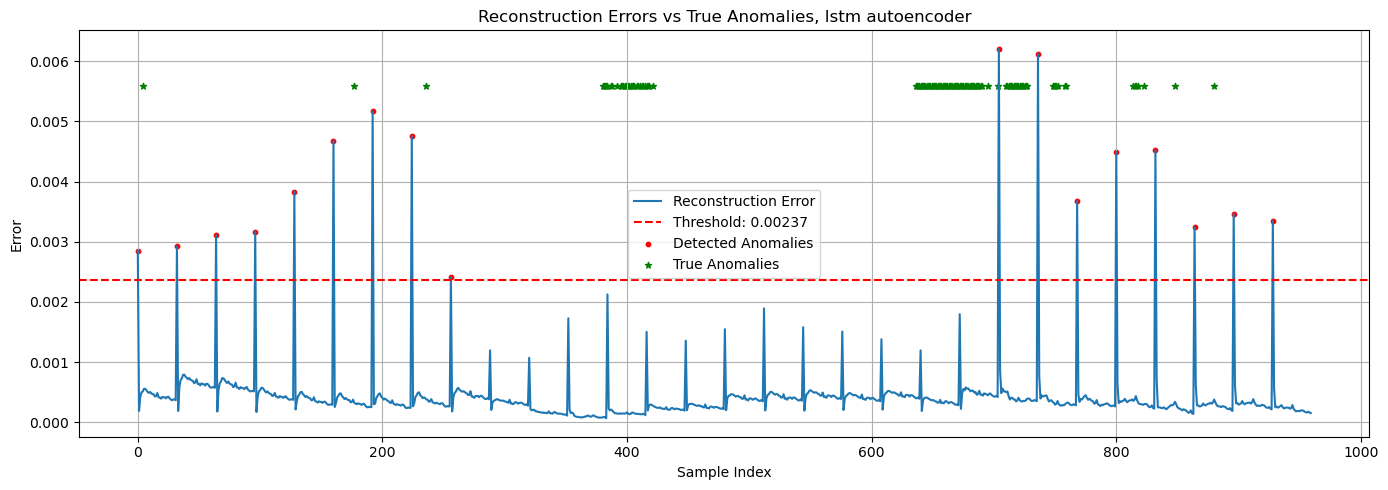

In [45]:
# === 0. Imports ===
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import joblib
import matplotlib.pyplot as plt

# === 1. Load Models ===
forecast_model = tf.keras.models.load_model("../results/forecast/AdaptedPatchTST/best_adapted_patchtst_forecaster.h5")
detection_model = tf.keras.models.load_model("../results/detection/LSTM-AE/best_lstm_autoencoder.h5")

# === 2. Load Scalers ===
forecast_scaler = joblib.load("../notebooks/forecast_scaler.pkl")
detection_scaler = joblib.load("../detection/scaler.pkl")

# === 3. Load Input CSV ===
file_path = "../detection_datasets/labeled_test_set_with_predictions.csv"  # full test set file
df = pd.read_csv(file_path)

if 'DateTime' in df.columns:
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df.set_index('DateTime', inplace=True)

if 'labels' in df.columns:
    test_labels = df['labels'].values
    df = df.drop(columns=['labels'])

# === 4. Normalize Input for Forecast Model ===
scaled_input = forecast_scaler.transform(df.values)
scaled_forecast = pd.DataFrame(scaled_input, index=df.index, columns=df.columns)

# === 5. Create Chained Forecast Sequences ===
INPUT_STEPS = 32
FORECAST_STEPS = 32

def create_chained_sequences(data, input_steps, forecast_steps):
    X, y = [], []
    i = 0
    while i + input_steps + forecast_steps <= len(data):
        input_seq = data[i:i + input_steps]
        output_seq = data[i + input_steps:i + input_steps + forecast_steps]
        X.append(input_seq)
        y.append(output_seq)
        i += forecast_steps
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X_forecast_seq, y_forecast_true = create_chained_sequences(scaled_forecast, INPUT_STEPS, FORECAST_STEPS)

# === 6. Simulate Real-Time Forecasting ===
forecast_list = []
true_windows = []

for i in range(len(X_forecast_seq)):
    input_seq = X_forecast_seq[i:i+1]
    y_true = y_forecast_true[i]
    y_pred = forecast_model.predict(input_seq, verbose=1)[0]
    forecast_list.append(y_pred)
    true_windows.append(y_true)



forecast_preds = np.array(forecast_list)
y_forecast_true = np.array(true_windows)

# === 7. Evaluate Forecast Model (Before De-normalization) ===
y_true_flat = y_forecast_true.reshape(-1)
y_pred_flat = forecast_preds.reshape(-1)
forecast_mse = mean_squared_error(y_true_flat, y_pred_flat)
forecast_mae = mean_absolute_error(y_true_flat, y_pred_flat)

print(f"\n📈 Forecast Evaluation:")
print(f"MSE: {forecast_mse:.5f}")
print(f"MAE: {forecast_mae:.5f}")

# === 8. De-normalize Forecasts for Detection ===
forecast_preds_reshaped = forecast_preds.reshape(-1, forecast_preds.shape[2])
denorm_forecasts = forecast_scaler.inverse_transform(forecast_preds_df)

# === 9. Re-normalize for Detection Model ===
scaled_for_detection = detection_scaler.transform(denorm_forecasts)

# === 10. Create Detection Sequences ===
def create_detection_sequences(data, input_steps):
    X = []
    for i in range(0, len(data) - input_steps + 1, input_steps):
        X.append(data[i:i+input_steps])
    return np.array(X, dtype=np.float32)

X_detection = create_detection_sequences(scaled_for_detection, INPUT_STEPS)

# === 11. Simulate Real-Time Anomaly Detection ===
reconstruction_errors = []
for i in range(len(X_detection)):
    input_seq = np.expand_dims(X_detection[i], axis=0)
    y_reconstructed = detection_model.predict(input_seq, verbose=1)[0]
    mse_error = np.mean((X_detection[i] - y_reconstructed) ** 2, axis=1)
    reconstruction_errors.append(mse_error)

all_reconstruction_errors = np.concatenate(reconstruction_errors)

min_len = min(len(test_labels), len(all_reconstruction_errors))
test_labels = test_labels[:min_len]
# all_detected = all_reconstruction_errors[:min_len]

# === 12. Thresholding ===
threshold = 0.002366
all_detected = (np.array(all_reconstruction_errors) > threshold).astype(np.int32)

# === 13. Evaluation Against Ground Truth Labels ===
original_test_labeled= df.copy()
original_test_labeled = original_test_labeled[:min_len]
original_test_labeled.loc[:, 'model-labels'] = all_detected


attribute  = "530R002D02.TI0037.MEAS"
attribute2 = "530M105D01.TIC0022.MEAS"
lower_bound = 674.7158203125
upper_bound = 740.859375


original_test_labeled.loc[
    (original_test_labeled[attribute2] < lower_bound) |
    (original_test_labeled[attribute] > upper_bound),
    'model-labels'
] = 1

precision = precision_score(test_labels, original_test_labeled['model-labels'], zero_division=0)
recall = recall_score(test_labels, original_test_labeled['model-labels'], zero_division=0)
f1 = f1_score(test_labels, original_test_labeled['model-labels'], zero_division=0)


# === 14. Print Results ===
print(f"\n🚨 Detection Evaluation:")
print(f"Precision: {precision:.5f}")
print(f"Recall:    {recall:.5f}")
print(f"F1 Score:  {f1:.5f}")

# === 15. Optional Plot ===
# Plot Reconstruction Errors with True Labels
plt.figure(figsize=(14,5))

# Ensure we're only plotting up to the minimum length we have data for
min_plot_len = min(len(all_reconstruction_errors), len(test_labels))
plot_errors = all_reconstruction_errors[:min_plot_len]
plot_labels = test_labels[:min_plot_len]
plot_detected = all_detected[:min_plot_len]

plt.plot(plot_errors, label='Reconstruction Error')
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.5f}')

# Detected anomalies
detected_indices = np.where(plot_detected == 1)[0]
plt.scatter(detected_indices,
            plot_errors[detected_indices],
            color='red', label='Detected Anomalies', s=10)

# True anomalies
true_anomaly_indices = np.where(plot_labels == 1)[0]
if len(true_anomaly_indices) > 0:
    plt.scatter(true_anomaly_indices,
                np.ones_like(true_anomaly_indices) * np.max(plot_errors)*0.9,
                color='green', marker='*', label='True Anomalies', s=20)
else:
    print("No true anomalies found in the subset of data being visualized")

plt.title("Reconstruction Errors vs True Anomalies, lstm autoencoder")
plt.xlabel("Sample Index")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("reconstruction_errors_with_threshold.png")
plt.show()

In [46]:
test_labels.shape

(960,)

In [47]:
all_detected.shape

(960,)

In [48]:
df.shape

(1000, 25)

In [49]:
scaled_for_detection.shape

(960, 25)

In [50]:
X_detection.shape

(30, 32, 25)

In [51]:
all_reconstruction_errors.shape

(960,)

In [52]:
reconstruction_errors

[array([0.0028448 , 0.00018808, 0.0004189 , 0.00049726, 0.0005104 ,
        0.00055532, 0.00055788, 0.00053396, 0.00050629, 0.00048754,
        0.00050384, 0.00048499, 0.00046632, 0.00046545, 0.00042951,
        0.00043639, 0.000487  , 0.00041548, 0.00041069, 0.00039321,
        0.00042081, 0.0004156 , 0.00041614, 0.00039825, 0.00042025,
        0.0004249 , 0.00039796, 0.00037878, 0.00036735, 0.00037765,
        0.00038069, 0.00036739], dtype=float32),
 array([0.00292568, 0.00018818, 0.00059076, 0.00070077, 0.0007301 ,
        0.00078903, 0.00079187, 0.00075982, 0.00073738, 0.00071717,
        0.00073768, 0.00070643, 0.00069778, 0.00068844, 0.00065025,
        0.00066176, 0.00071532, 0.00063748, 0.0006388 , 0.00061339,
        0.00064726, 0.00063445, 0.00063445, 0.00060964, 0.00064063,
        0.00063865, 0.00061577, 0.00058425, 0.00057609, 0.00057908,
        0.0005898 , 0.00057253], dtype=float32),
 array([0.00310875, 0.00017926, 0.00054022, 0.00064799, 0.00067678,
        0.00073428

In [53]:
denorm_forecasts[400]

array([ 8.3332535e+01,  4.6923943e+00,  1.2717954e+02,  8.6805367e+04,
        2.6552446e+03,  1.1664294e+03, -2.0538214e+02,  2.1463872e+03,
        3.0894308e+02,  1.3266760e+02,  8.4272337e+00,  6.4666260e+01,
        2.9425779e+01,  7.2745636e+02,  7.8260968e+02,  1.7927992e+00,
        7.3819208e+02,  1.4209061e+02,  6.8173572e+02,  1.5920552e+02,
        1.9204336e+01,  2.2891991e+01,  5.9914108e+01,  1.1747428e+01,
        5.7014942e+01], dtype=float32)

In [54]:
forecast_preds_reshaped[0]

array([ 0.6109052 ,  0.76131743,  0.6475308 ,  0.6454102 ,  0.795996  ,
        0.52765584, -0.09700364,  0.17810246,  0.41753846,  0.60873073,
        0.5184736 ,  0.6687789 ,  0.38430607,  0.37448624,  0.27302003,
        0.8479747 ,  0.32455093,  0.1321519 ,  0.53671205,  0.14580314,
        0.5797506 ,  0.5686152 ,  0.38627613,  0.5914959 ,  0.22962803],
      dtype=float32)

In [55]:
forecast_preds_reshaped.shape

(960, 25)

In [56]:
scaled_forecast.shape

(1000, 25)

In [ ]:
forecast_preds_reshaped[400]

array([ 0.6913191 ,  0.8654701 ,  0.82215524,  0.67544794,  0.88855946,
        0.7223674 , -0.06169022,  0.22965428,  0.511644  ,  0.7788271 ,
        0.55259776,  0.7855587 ,  0.45549384,  0.3877434 ,  0.31903246,
        1.0084552 ,  0.47330683,  0.38943753,  0.6253706 ,  0.39961186,
        0.460614  ,  0.74790925,  0.36930096,  0.20832336,  0.4366845 ],
      dtype=float32)

In [ ]:
print(y_true_flat.shape)
print(y_pred_flat.shape)

(24000,)
(24000,)


In [ ]:
forecast_preds.shape

(30, 32, 25)